### **Connecting to drive**

In [1]:
# #Reading the training data Subject
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


### **Importing required Libraries**

In [2]:
#Importing all needed libraries
import pandas as pd
import numpy as np #Matric math
import tensorflow as tf #ML
from tensorflow.python.framework import ops
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import sys
import os
from scipy.io import loadmat
from scipy.io import loadmat

# sys.path.append(os.path.abspath("/Users/henda/anaconda3/Lib/site-packages"))
# from rnn_utils import *
# from public_tests import *
ops.reset_default_graph()

tf.compat.v1.reset_default_graph() #Clearning cache
sess=tf.compat.v1.InteractiveSession()




### **Reading the Dataset**

In [3]:
data_path = '/content/drive/My Drive/Colab Notebooks/processed withstim/S1_E1.mat'


training_data = loadmat(data_path)

Data=training_data["Data"]
Data1=np.array(Data)

print(Data1.shape)

#####################################################



(9147, 83)


### **Defining model**

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, Dense, Dropout, LSTM, Bidirectional, Add, LayerNormalization, Input, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras import activations
import torch
import torch.optim as optim
import torch.nn as nn



# Define model input
timesteps = 15  # Number of timesteps (sequence length)
input_features = 24
numResponses = 22

import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, input_dim=24, head_size=256, num_heads=4, dropout_prob=0.25):
        super(TransformerBlock, self).__init__()

        # Linear layer to project input_dim (24) to head_size (256)
        self.input_projection = nn.Linear(input_dim, head_size)

        # Normalization and Multihead Attention
        self.norm1 = nn.LayerNorm(head_size, eps=1e-6)
        self.attention = nn.MultiheadAttention(embed_dim=head_size, num_heads=num_heads, dropout=0)

        # Dropout layer after attention
        self.dropout1 = nn.Dropout(0)

        # Feedforward part
        self.norm2 = nn.LayerNorm(head_size, eps=1e-6)

        # First Convolutional Layer (manual padding to ensure sequence length is unchanged)
        self.padding = nn.ConstantPad1d((1, 0), 0)  # Adds padding only on one side
        self.conv1 = nn.Conv1d(head_size, 3, kernel_size=2)
        self.dropout2 = nn.Dropout(dropout_prob)

        # Second Convolutional Layer (no padding needed for 1x1 convolution)
        self.conv2 = nn.Conv1d(3, head_size, kernel_size=1)

    def forward(self, x):
        # Project input to head_size (256)
        x = self.input_projection(x)  # (batch, sequence, head_size)

        # Adjust shape for multihead attention (sequence, batch, features)
        x = x.permute(1, 0, 2)

        # Multihead Attention
        x_norm = self.norm1(x)
        attn_output, _ = self.attention(x_norm, x_norm, x_norm)
        x = x + self.dropout1(attn_output)

        # Feedforward part
        x_norm = self.norm2(x)
        x_norm = x_norm.permute(1, 2, 0)  # (batch, features, sequence) for Conv1d

        # Apply padding only before the first convolution
        x_padded = self.padding(x_norm)  # Apply padding to maintain sequence length
        x_conv = F.relu(self.conv1(x_padded))

        x_conv = self.dropout2(x_conv)
        x_conv = self.conv2(x_conv)
        x_conv = x_conv.permute(2, 0, 1)  # Back to (sequence, batch, features)

        # Residual connection
        x = x + x_conv
        return x.permute(1, 0, 2)  # Return to (batch, sequence, features)

class RegressionBlock(nn.Module):
    def __init__(self, input_dim=256, output_dim=22):
        super(RegressionBlock, self).__init__()

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # MLP Layers
        self.mlp1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.4)
        self.mlp2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Global Average Pooling along the sequence dimension
        x = x.permute(0, 2, 1)  # (batch, features, sequence)
        x = self.global_avg_pool(x).squeeze(-1)  # (batch, features)
        x = F.relu(self.mlp1(x))
        x = self.dropout1(x)
        x = self.mlp2(x)
        return x

class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_dim=24, output_dim=22, num_transformer_blocks=4, head_size=256):
        super(DeepNeuralNetwork, self).__init__()

        # Transformer Blocks
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(input_dim=input_dim if i == 0 else head_size) for i in range(num_transformer_blocks)]
        )

        # Regression Block
        self.regression_block = RegressionBlock(input_dim=head_size, output_dim=output_dim)

    def forward(self, x):
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = self.regression_block(x)
        return x





### **Entire code and cross validation**

In [ ]:
tf.keras.backend.clear_session()

In [16]:
import numpy as np
import math
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import mean_squared_error

# Define sequence length and input/output dimensions
sequence_length = 15
n_features = 24
output_dof = 22

# Prepare storage for Pearson correlation and MSE for each fold
pearson = {i: [] for i in range(1, output_dof + 1)}
mse = {i: [] for i in range(1, output_dof + 1)}
# Labels range from 1 to 17 (excluding 0)
labels = list(range(1, 18))

# Check unique labels in Data1 and their counts (assuming the label is in the last column)
unique_labels, counts = np.unique(Data1[:, -1], return_counts=True)
available_labels = dict(zip(unique_labels, counts))

# Print available labels and counts for debugging
print("Available labels and their counts:", available_labels)

# Filter out labels that have data
valid_labels = [label for label, count in available_labels.items() if count > 0 and label != 0]


# Loop over 10-fold cross-validation
for fold in range(1, 11):
    # Randomly select 3 different labels for testing
    test_labels = np.random.choice(valid_labels, 4, replace=False)
    print(f"Test labels for fold {fold}: {test_labels}")

    # Split data into training and testing sets based on selected labels
    D_test = Data1[np.isin(Data1[:, -1], test_labels)]
    D_train = Data1[~np.isin(Data1[:, -1], test_labels)]

    # Extract features and targets
    X_train = D_train[:, 36:58]
    Z_train = D_train[:, 58:82]
    X_test = D_test[:, 36:58]
    Z_test = D_test[:, 58:82]

    # Prepare input/output sequences for training and testing
    n_sequences_train = len(Z_train) - sequence_length + 1
    in_train = np.zeros((n_sequences_train, sequence_length, n_features))
    out_train = np.zeros((n_sequences_train, X_train.shape[1]))

    for j in range(n_sequences_train):
        in_train[j] = Z_train[j:j + sequence_length]
        out_train[j] = X_train[j + sequence_length - 1]

    n_sequences_test = len(Z_test) - sequence_length + 1
    in_test = np.zeros((n_sequences_test, sequence_length, n_features))
    out_test = np.zeros((n_sequences_test, X_test.shape[1]))

    for j in range(n_sequences_test):
        in_test[j] = Z_test[j:j + sequence_length]
        out_test[j] = X_test[j + sequence_length - 1]

    # Convert data to PyTorch tensors
    in_train = torch.tensor(in_train, dtype=torch.float32)
    out_train = torch.tensor(out_train, dtype=torch.float32)
    in_test = torch.tensor(in_test, dtype=torch.float32)
    out_test = torch.tensor(out_test, dtype=torch.float32)

    ######### Model Setup ##########
    model = DeepNeuralNetwork(input_dim=n_features, output_dim=output_dof, num_transformer_blocks=4)
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    ######### Training ##########
    num_epochs = 200
    best_val_loss = float('inf')
    patience = 80
    patience_counter = 0
    batch_size = 32

    for epoch in range(num_epochs):
        model.train()  # Training mode
        optimizer.zero_grad()

        # Forward pass
        predictions = model(in_train)
        train_loss = criterion(predictions, out_train)

        # Backward pass
        train_loss.backward()
        optimizer.step()

        # Validation on a split of the training data
        with torch.no_grad():
            model.eval()
            val_predictions = model(in_train[:int(0.2 * len(in_train))])
            val_loss = criterion(val_predictions, out_train[:int(0.2 * len(out_train))])

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Reduce learning rate on plateau
        if epoch % 10 == 0 and patience_counter >= 3:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    ######### Model Testing ##########
    model.eval()
    with torch.no_grad():
        test_predictions = model(in_test)
        test_loss = criterion(test_predictions, out_test)
        print(f'Test Loss for fold {fold}: {test_loss.item():.4f}')

    # Convert outputs and predictions to numpy for evaluation
    output_predicted = test_predictions.numpy()
    out_test_final = out_test.numpy()

    ######### Evaluation ##########
    for k in range(1, output_dof + 1):
        # Calculate Pearson correlation
        cc_value = np.corrcoef(out_test_final[:, k - 1], output_predicted[:, k - 1])[0, 1]
        pearson[k].append(round(cc_value, 2))

        # Calculate RMSE
        rmse_value = math.sqrt(mean_squared_error(out_test_final[:, k - 1], output_predicted[:, k - 1]))
        mse[k].append(round(rmse_value, 2))

        print(f"Pearson correlation for DOF {k} in fold {fold}: {pearson[k][-1]}")
        print(f"RMSE for DOF {k} in fold {fold}: {mse[k][-1]}")


Fold 1
Training input shape: torch.Size([8226, 15, 24]) Training target shape: torch.Size([8226, 22])
Testing input shape: torch.Size([893, 15, 24]) Testing target shape: torch.Size([893, 22])
Epoch 10/200, Training Loss: 0.0894, Validation Loss: 0.0314
Epoch 20/200, Training Loss: 0.0671, Validation Loss: 0.0177
Epoch 30/200, Training Loss: 0.0549, Validation Loss: 0.0156
Epoch 40/200, Training Loss: 0.0501, Validation Loss: 0.0132
Epoch 50/200, Training Loss: 0.0467, Validation Loss: 0.0130
Epoch 60/200, Training Loss: 0.0447, Validation Loss: 0.0131
Epoch 70/200, Training Loss: 0.0434, Validation Loss: 0.0130
Epoch 80/200, Training Loss: 0.0433, Validation Loss: 0.0127
Epoch 90/200, Training Loss: 0.0431, Validation Loss: 0.0128
Epoch 100/200, Training Loss: 0.0428, Validation Loss: 0.0128
Epoch 110/200, Training Loss: 0.0430, Validation Loss: 0.0127
Epoch 120/200, Training Loss: 0.0427, Validation Loss: 0.0127
Epoch 130/200, Training Loss: 0.0428, Validation Loss: 0.0127
Epoch 140/

In [17]:
for i in range (1,23):
 # Getting cc and rmse
  print(f"CC:{pearson[i]}")
 # print("RMSE: %s" % mse[i])



CC:[0.64, 0.68, 0.68, 0.73, 0.62, 0.61, 0.58, 0.59, 0.64, 0.6]
CC:[0.07, 0.35, 0.14, 0.14, 0.31, 0.08, 0.45, 0.16, 0.52, 0.18]
CC:[0.4, 0.63, 0.53, 0.66, 0.63, 0.47, 0.46, 0.37, 0.67, -0.03]
CC:[0.56, 0.74, 0.58, 0.63, 0.52, 0.63, 0.59, 0.57, 0.65, 0.45]
CC:[0.78, 0.77, 0.8, 0.61, 0.77, 0.69, 0.68, 0.74, 0.72, 0.8]
CC:[0.68, 0.75, 0.76, 0.55, 0.71, 0.59, 0.71, 0.64, 0.64, 0.78]
CC:[0.0, 0.41, 0.07, -0.05, 0.06, 0.41, 0.15, 0.54, 0.48, -0.31]
CC:[0.75, 0.77, 0.8, 0.68, 0.8, 0.74, 0.72, 0.78, 0.75, 0.81]
CC:[0.69, 0.82, 0.77, 0.73, 0.79, 0.72, 0.75, 0.77, 0.69, 0.83]
CC:[0.15, 0.3, 0.34, 0.21, 0.47, 0.08, 0.51, 0.18, 0.41, 0.19]
CC:[0.32, 0.69, 0.58, 0.51, 0.59, 0.36, 0.72, 0.72, 0.67, 0.03]
CC:[0.77, 0.78, 0.8, 0.75, 0.73, 0.66, 0.69, 0.8, 0.79, 0.72]
CC:[0.68, 0.83, 0.84, 0.8, 0.73, 0.76, 0.79, 0.83, 0.77, 0.79]
CC:[-0.02, 0.54, 0.49, 0.46, 0.67, 0.21, 0.66, 0.61, 0.63, 0.47]
CC:[0.14, 0.58, 0.43, 0.33, 0.53, 0.53, 0.61, 0.67, 0.54, 0.29]
CC:[0.78, 0.79, 0.8, 0.76, 0.73, 0.61, 0.63, 0.

In [18]:
  print("CC: %s" %np.corrcoef(out_test[:,1],output_predicted[:,1]))


CC: [[1.        0.1833761]
 [0.1833761 1.       ]]


### **Get the mean and std of CC and RMSE**

In [19]:
cc=[]
cstd=[]
rms=[]
rmsstd=[]
for i in range(1, 23):
  print("CC Mean %s: %s" % (i , np.mean(pearson[i])))
  print("CC STD %s: %s" % (i , np.std(pearson[i])))
  print("----------------------------------------")
  cc.append(np.mean(pearson[i]))
  cstd.append(np.std(pearson[i]))

for i in range (1,23):
  print("RMSE Mean %s: %s"  %(i, np.mean(mse[i])))
  print("RMSE STD %s: %s"  %(i, np.std(mse[i])))
  print("----------------------------------------")
  rms.append(np.mean(mse[i]))
  rmsstd.append(np.std(mse[i]))




CC Mean 1: 0.637
CC STD 1: 0.044955533585978064
----------------------------------------
CC Mean 2: 0.24
CC STD 2: 0.14966629547095764
----------------------------------------
CC Mean 3: 0.479
CC STD 3: 0.19876870981117728
----------------------------------------
CC Mean 4: 0.592
CC STD 4: 0.07426977851050856
----------------------------------------
CC Mean 5: 0.736
CC STD 5: 0.05817215828899597
----------------------------------------
CC Mean 6: 0.681
CC STD 6: 0.07161703707917551
----------------------------------------
CC Mean 7: 0.17600000000000002
CC STD 7: 0.2603920121662721
----------------------------------------
CC Mean 8: 0.76
CC STD 8: 0.0384707681233427
----------------------------------------
CC Mean 9: 0.756
CC STD 9: 0.0467332857821917
----------------------------------------
CC Mean 10: 0.284
CC STD 10: 0.1377098398808161
----------------------------------------
CC Mean 11: 0.5189999999999999
CC STD 11: 0.21111371343425323
----------------------------------------
CC Mea

In [ ]:
# #Save data in excel file

# import openpyxl

# # Load the existing workbook
# from google.colab import drive
# workbook_path = '/content/drive/My Drive/Colab Notebooks/dataset/Ninapro CNN-LSTM-Transformer Subjectdependant.xlsx'

# wb = openpyxl.load_workbook(workbook_path)


# # Select the active sheet
# sheet = wb.active

# row_name = 'S1'  # Change this to the appropriate row name for each run

# # Find the row with the specified row name
# for row in sheet.iter_rows(min_row=1, max_row=sheet.max_row):
#     if row[0].value == row_name:
#         target_row = row[0].row
#         break

# # Write the data to the found row, starting from the second column
# for col, value in enumerate(cc, start=2):  # start=2 to skip the first column for the label
#     sheet.cell(row=target_row, column=col, value=value)

# # Save the workbook
# wb.save(workbook_path)


### **plot predicted vs actual**

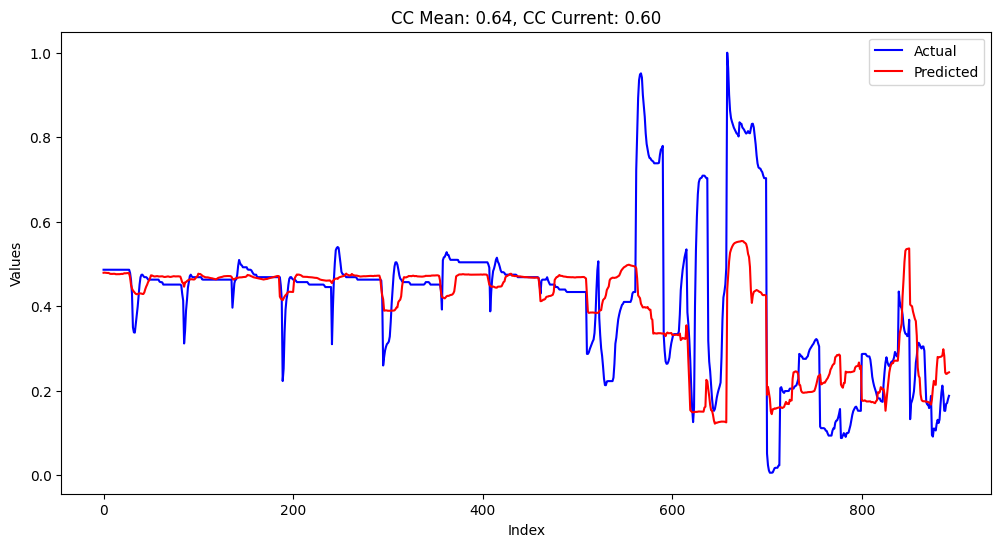

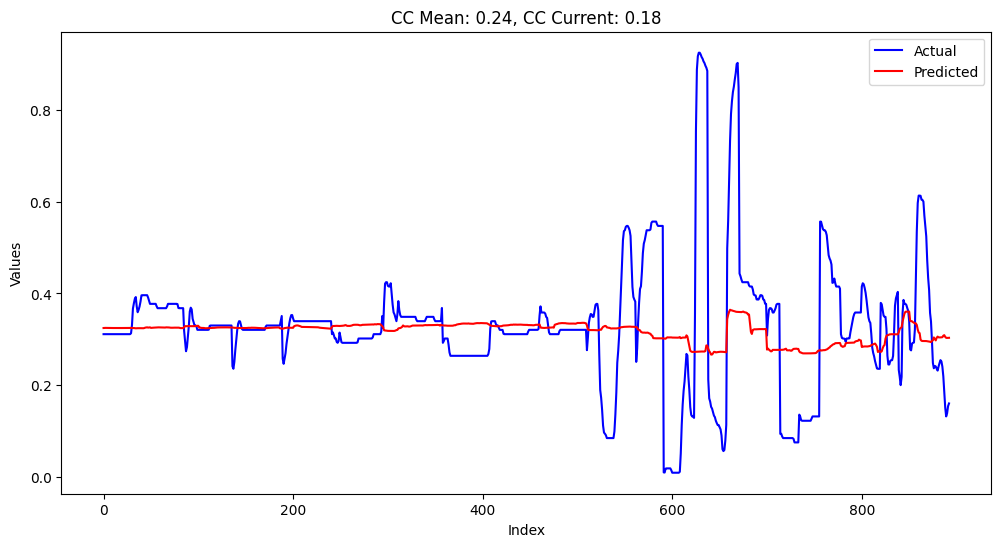

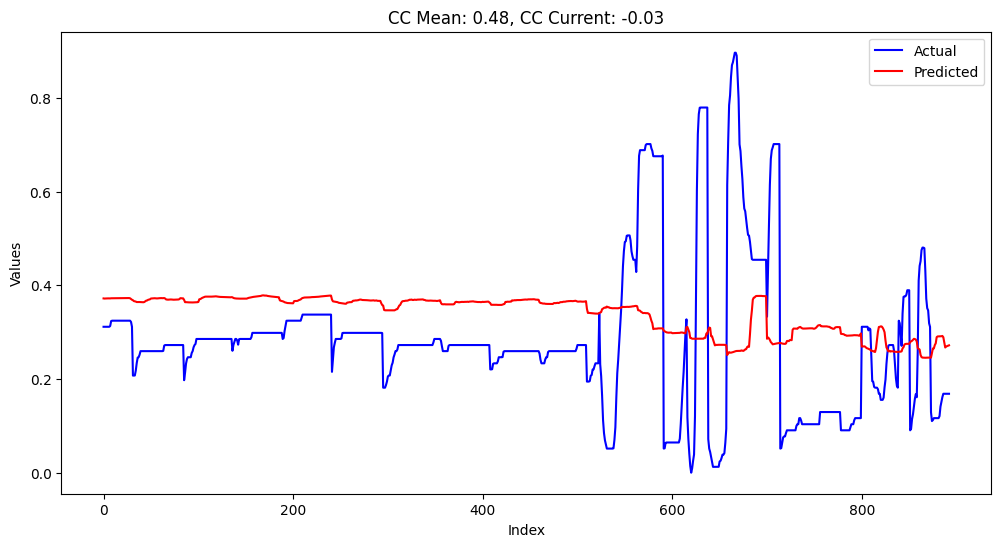

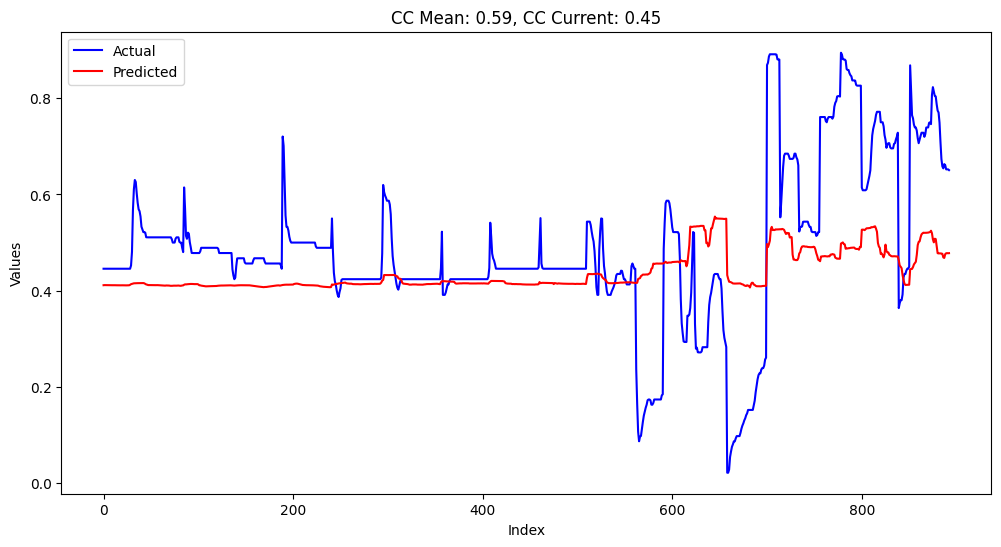

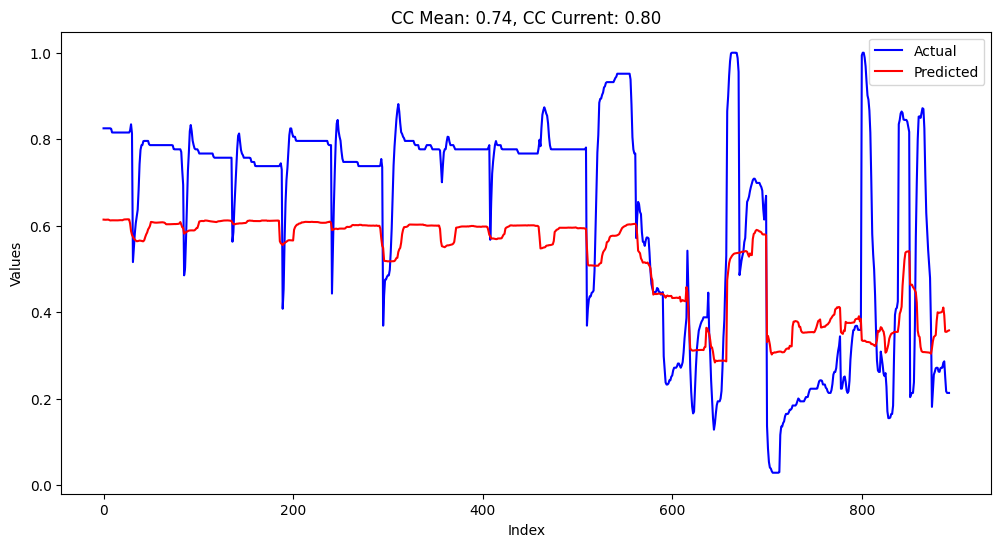

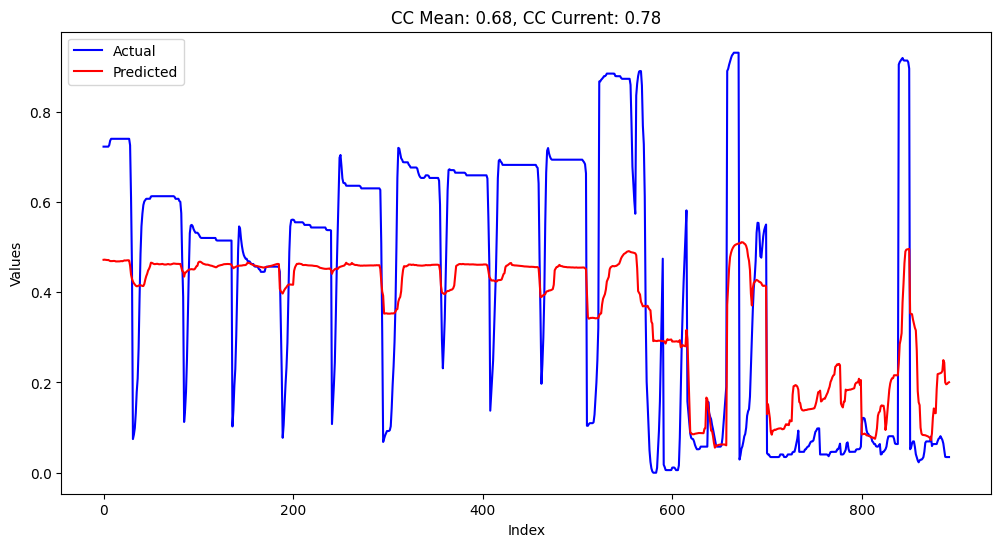

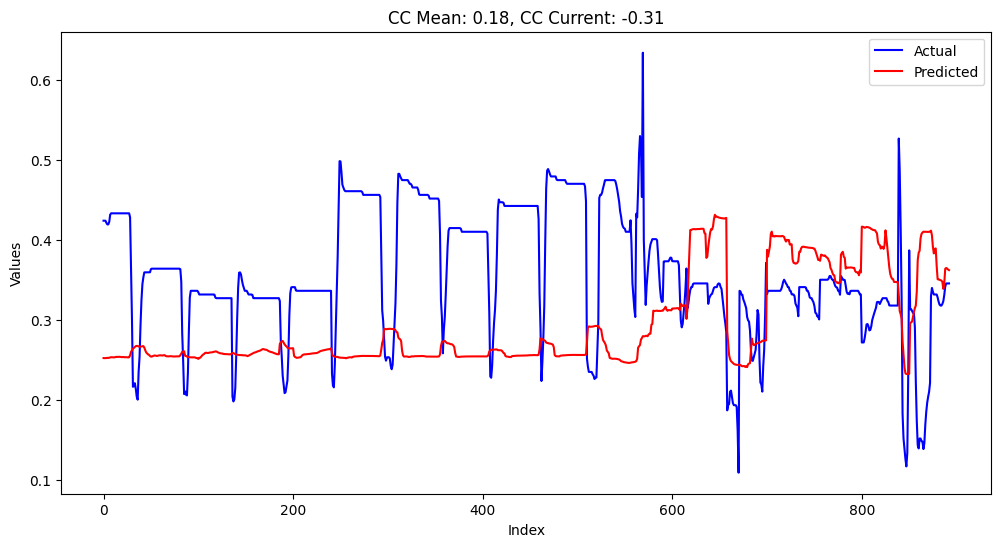

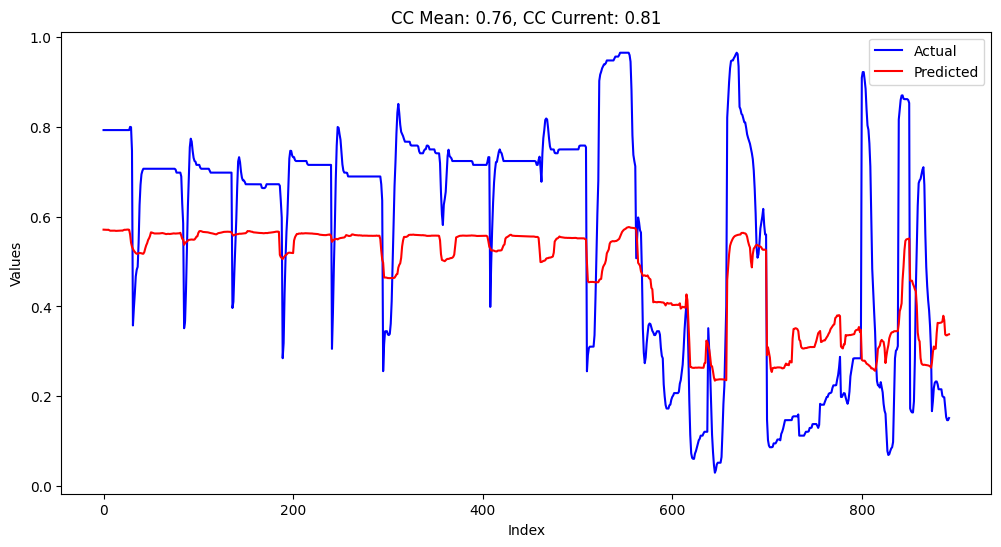

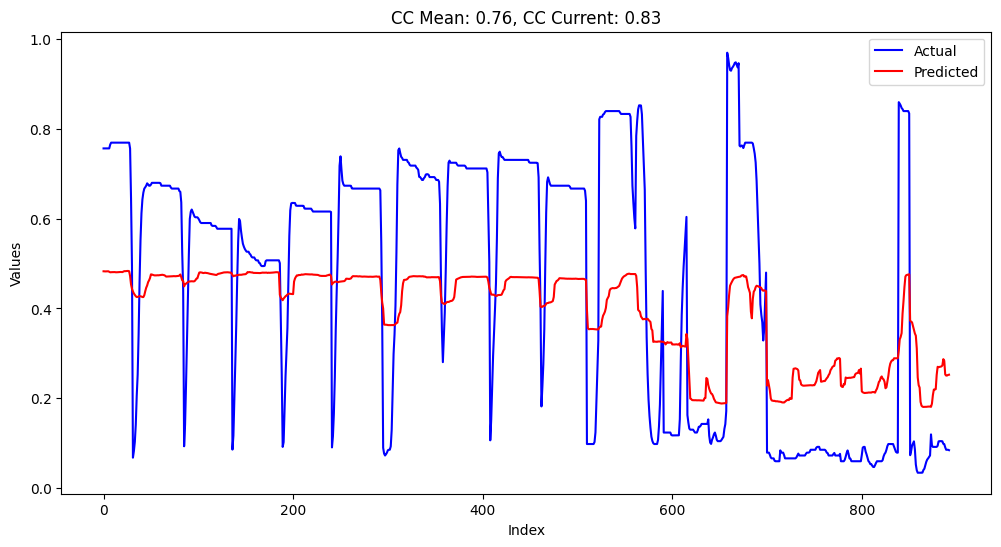

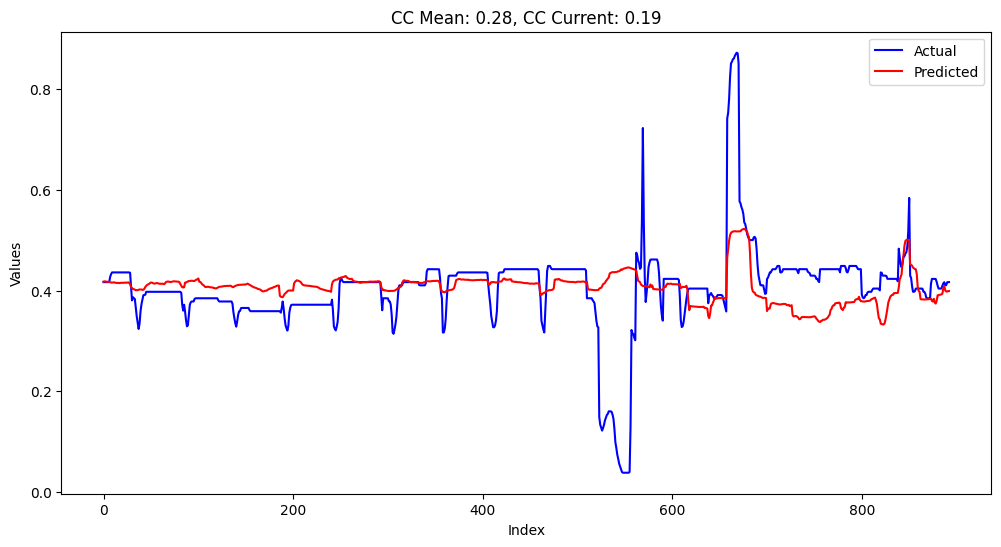

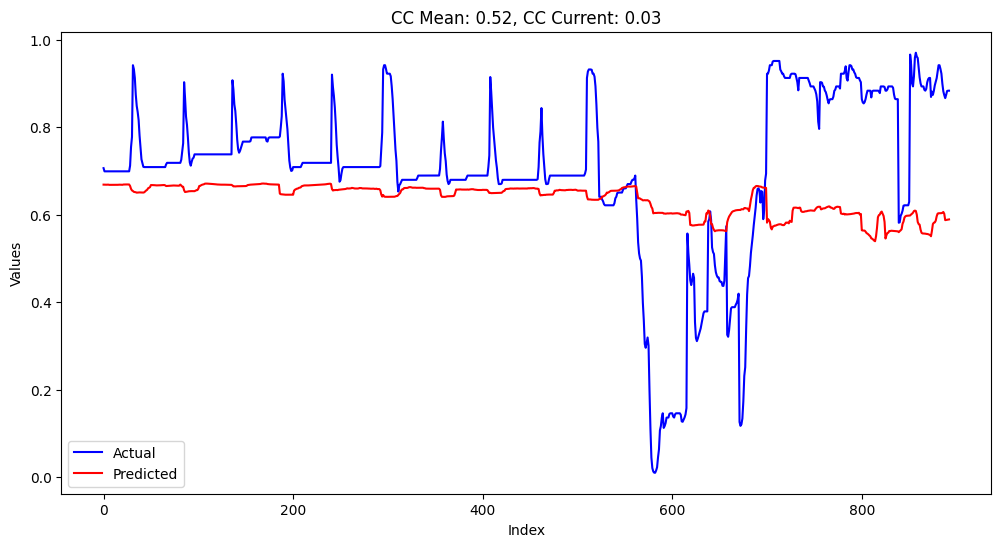

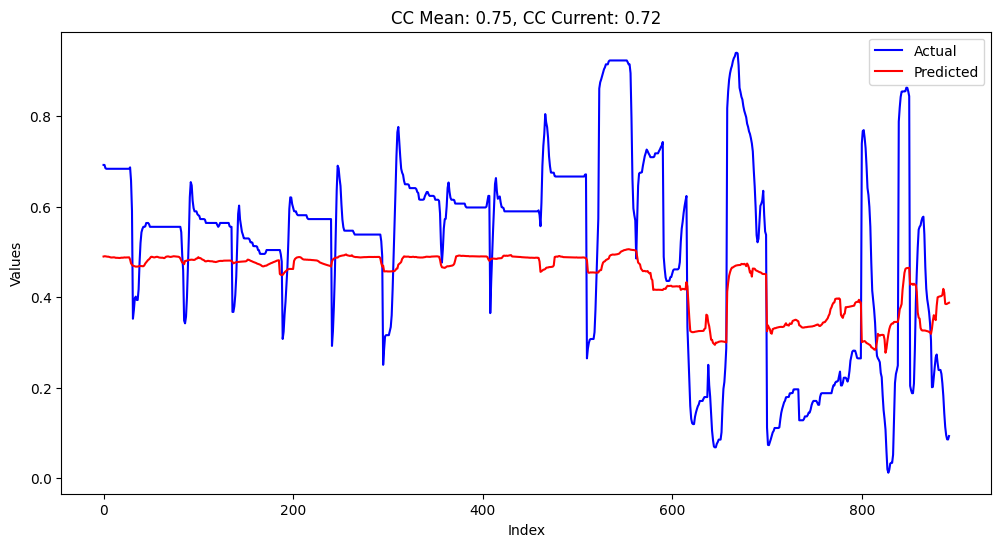

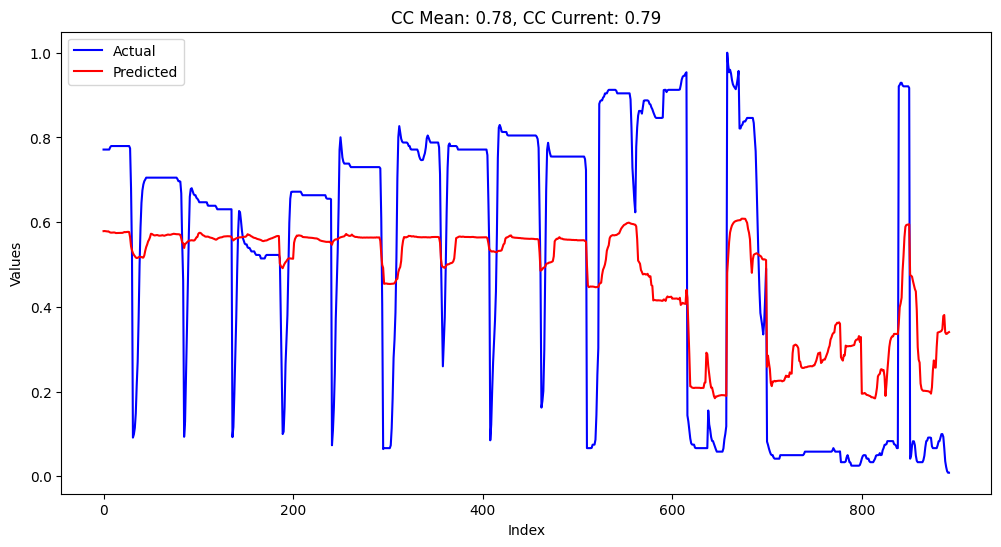

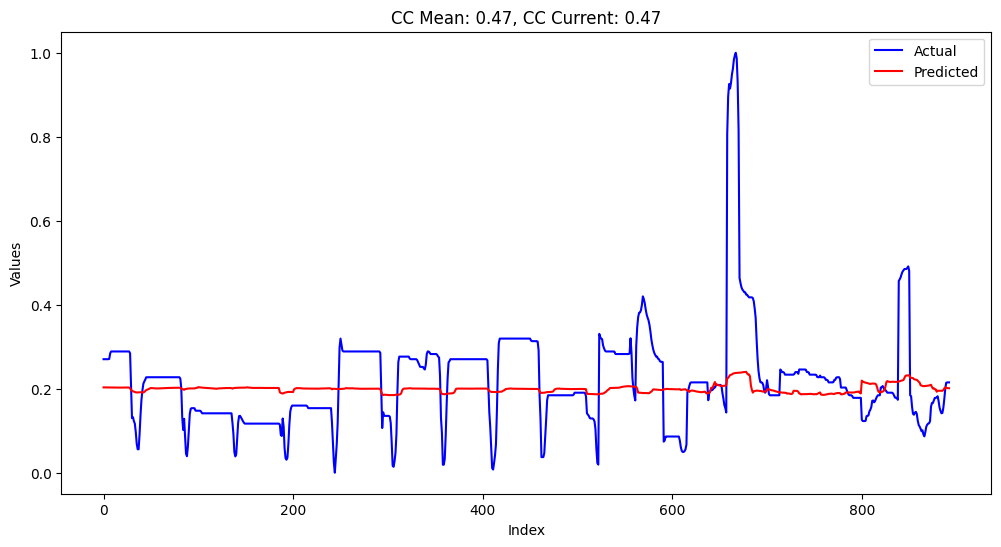

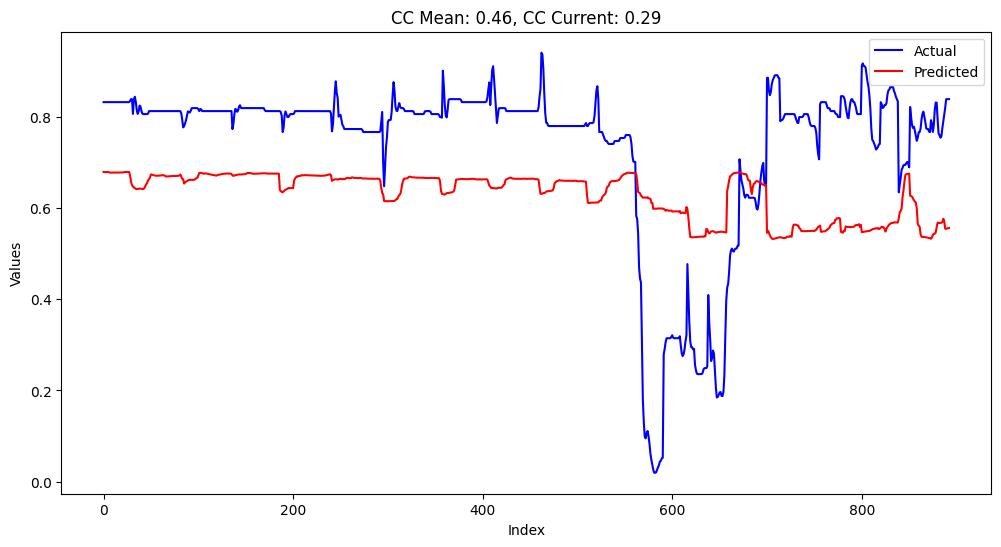

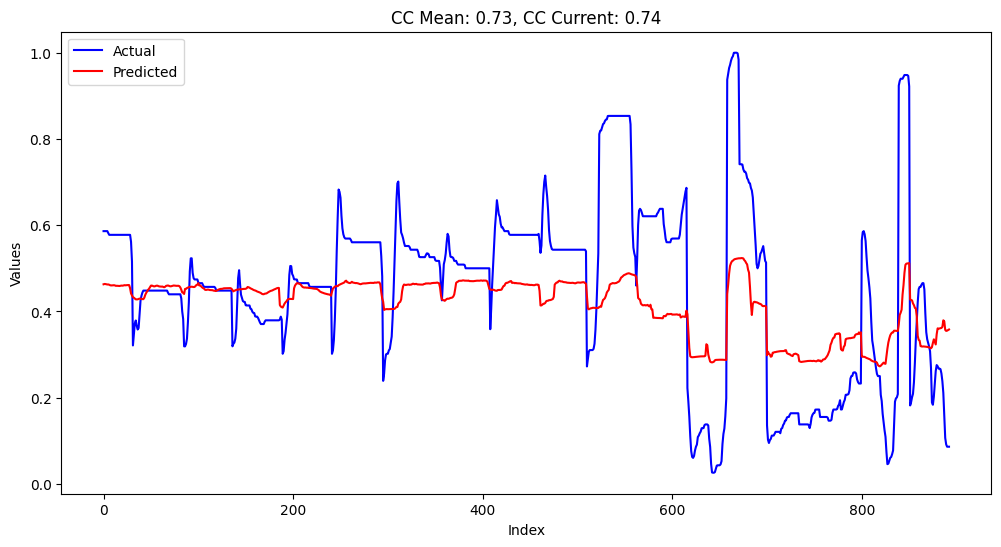

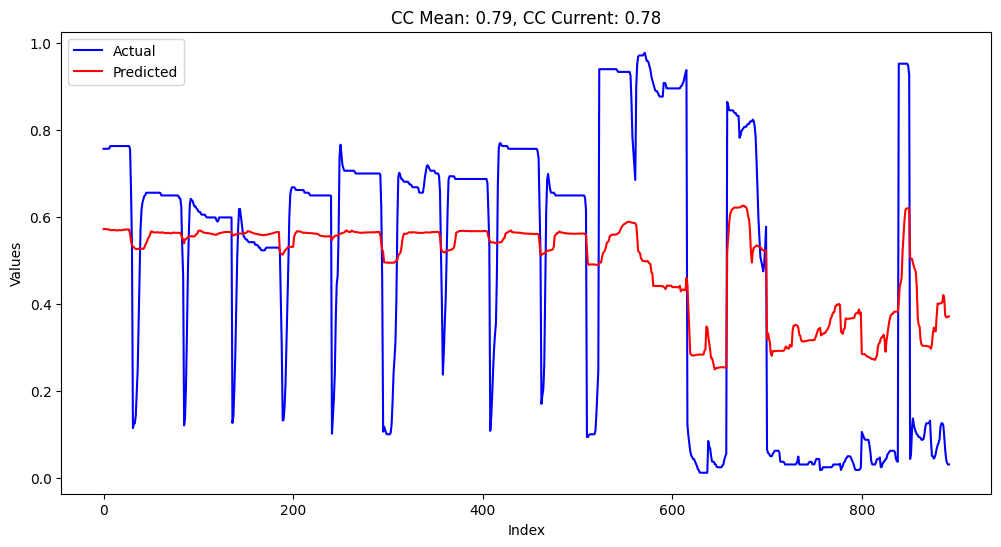

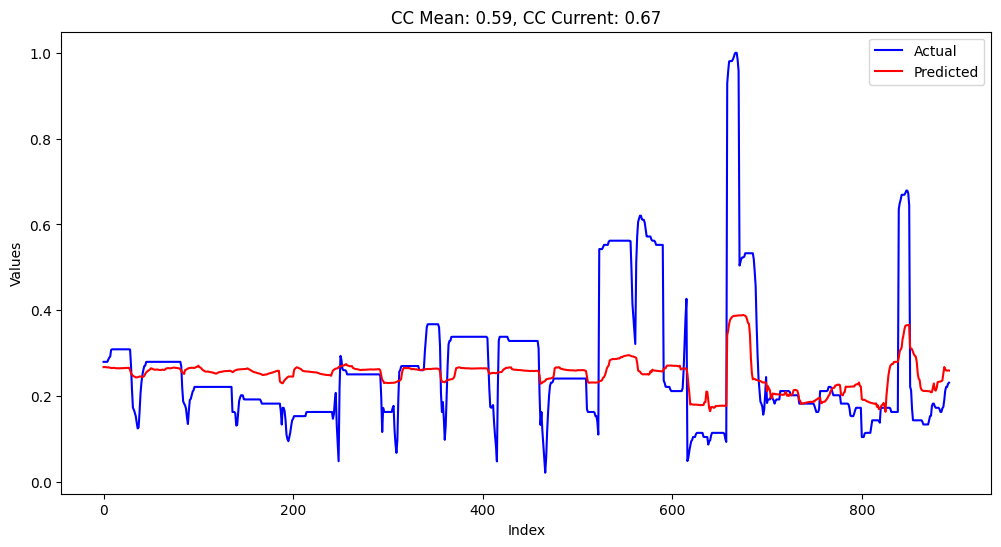

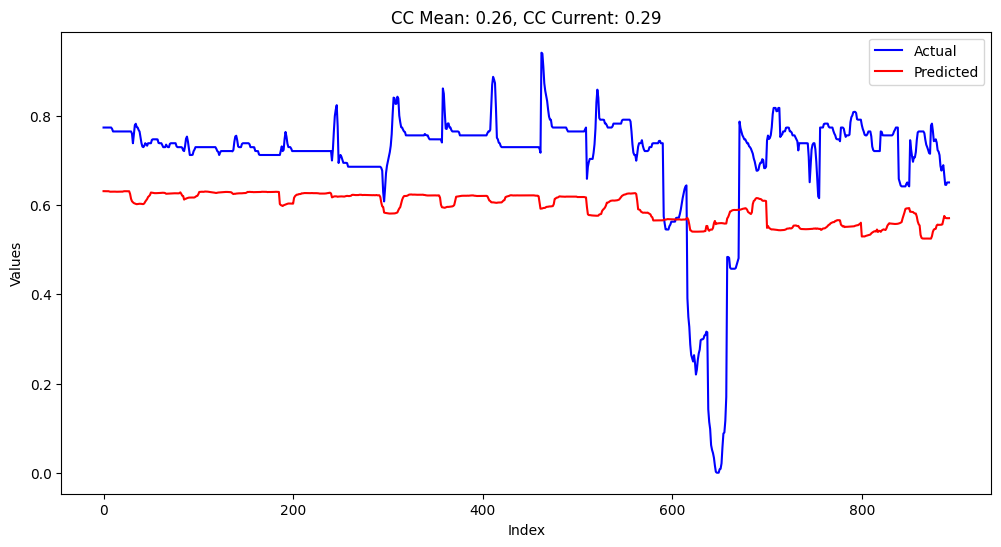

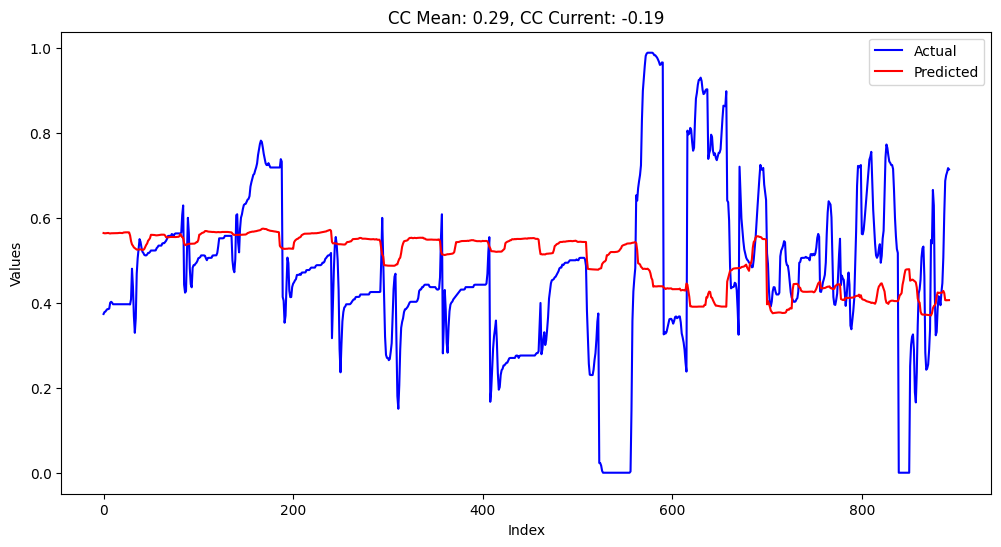

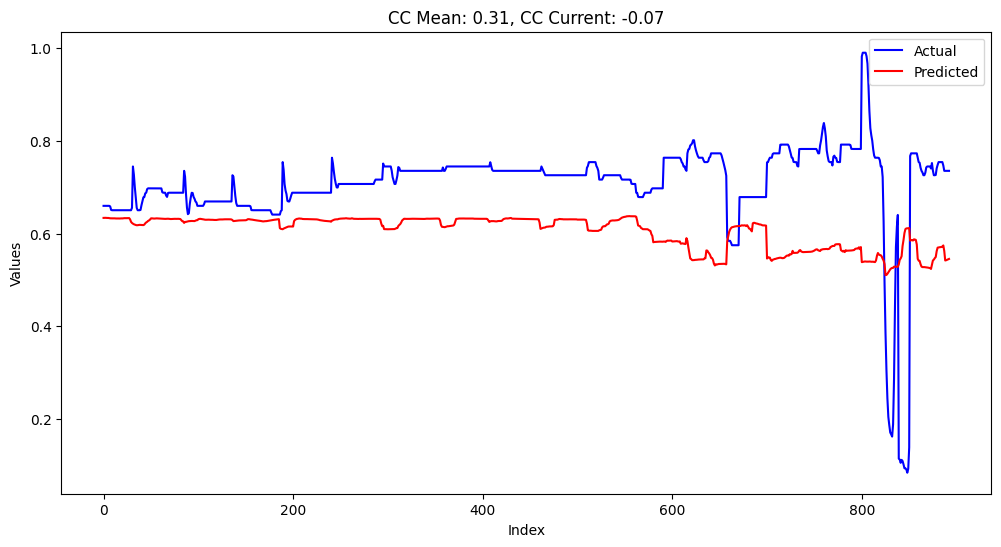

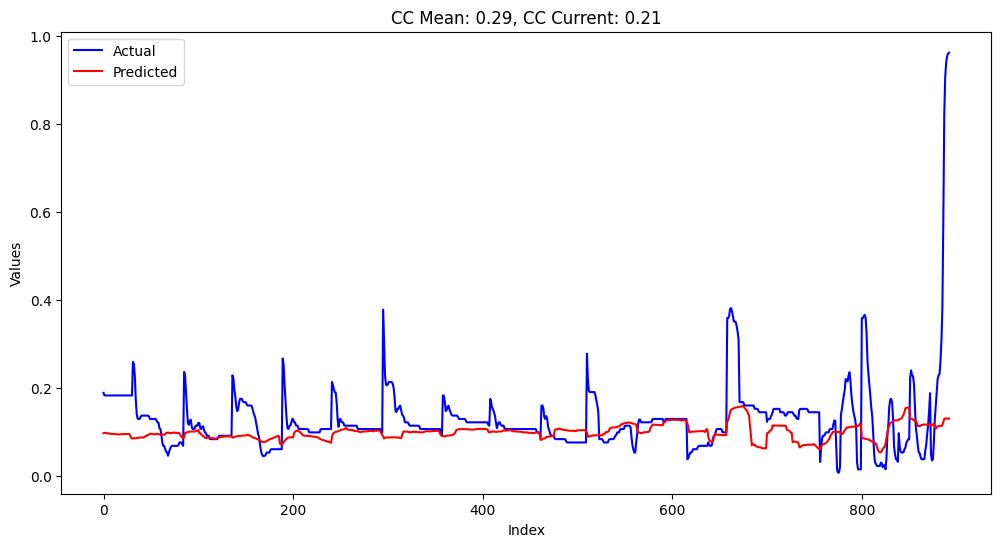

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

for i in range (0,22):
  n_rows = out_test.shape[0]
  x = np.arange(n_rows)

  y1 = out_test[:, i]  # Column
  y2 = output_predicted[:, i]

  plt.figure(figsize=(12, 6))

  # Plotting each column
  plt.plot(x, y1, label='Actual', color='blue')  # Line for column 1
  plt.plot(x, y2, label='Predicted', color='red')  # Line for column 2
  # Calculate the mean and current correlation coefficient separately
  cc_mean = np.mean(pearson[i+1])
  cc_current = np.corrcoef(out_test[:, i], output_predicted[:, i])[0, 1]
  # Combine them into the plot title
  plot_title = "CC Mean: {:.2f}, CC Current: {:.2f}".format(cc_mean, cc_current)

  plt.title(plot_title)
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.legend()

  plt.show()
